In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image, ImageOps, ImageFilter

# import imutils
# import itertools
# import shutil
# import random
# import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Processing Covid19 Patients ECG images

In [ ]:
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma
 
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
 
    return cv2.LUT(src, table)

In [ ]:
pwd

'/content'

In [ ]:
main_path = "C:\\Users\\anant\\jupyterBooks\\LectureNotebooks\\2022W\\AML_2404_LAB\\data1"

main_path = '/content/drive/My Drive/second sem/lab/AIML lab]/Files/working'

for foldername in os.listdir(main_path): # looping over the different class folder
    
    folder = main_path+"/"+foldername+"/"
    Copy_to_path = folder+"/processed/"

    for index, filename in enumerate(os.listdir(folder)): # retrieving the image files in particular folder
        
        if filename != 'processed':
            
            image = cv2.imread(folder+filename, cv2.IMREAD_GRAYSCALE) # grayscale

            enhance = cv2.equalizeHist(image) # equalize histogram used to enchance the lines

            thrsh = cv2.adaptiveThreshold(enhance,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,41,21) 

            contrs, _ = cv2.findContours(thrsh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) # using threshold to get the contours
            contrs = list(contrs)

            c = max(contrs, key = cv2.contourArea) # getting the largest contours that is the largest shape ( image boundary )

            print(c.shape)
            if c.shape[0] <= 4:            

                contrs.remove(max(contrs, key = cv2.contourArea)) # removing the frame

                c = max(contrs, key = cv2.contourArea) # again getting the largest frame that is the pulse frame

                x,y,w,h = cv2.boundingRect(c) # getting the co-ordinates


                rect = image[y:y+h, x:x+w] # cropping the frame

                cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),10) # drawing rectangle with the co-ordinates

                gamma_corrected = gammaCorrection(rect,3) # gamma correction

                (thresh, im_bw) = cv2.threshold(gamma_corrected, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # threshold is increased

                im_bw_resize = cv2.resize(im_bw,(720, 576)) # resizing the image to 256
                img = Image.fromarray(im_bw_resize)
                print(filename, " ", index)
                img.save(Copy_to_path+f'{foldername}_{index}.jpg', 'JPEG')
        else:
            pass

### Data Augmentation


In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, img_to_array

In [ ]:
main_path = "C:\\Users\\anant\\jupyterBooks\\LectureNotebooks\\2022W\\AML_2404_LAB\\data1"
augmented_path = "C:\\Users\\anant\\jupyterBooks\\LectureNotebooks\\2022W\\AML_2404_LAB\\data1\\augmented"

data_gen_args = dict(
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     fill_mode='constant',
                     cval=255
                    )
image_datagen = ImageDataGenerator(**data_gen_args)

for foldername in os.listdir(main_path): # looping over the different class folder
    if foldername != 'augmented':
        
        folder = main_path+"\\"+foldername+"\\processed\\"

        Copy_to_path = augmented_path+'\\'+foldername+'\\'
        print(Copy_to_path)

    #     determining the files count in each category
    #     we want 7500 images in final dataset
    #     we have five categories
    #     so we need 1500 images in each category
        files_count = os.listdir(folder) 
        print(len(files_count))

        total_image_present = len(files_count)
        img_batch_size = round(2000/total_image_present)
        if img_batch_size > 8 :
            img_batch_size = 8

        print(f"batch size for {foldername} category is {img_batch_size}")
        file_count = 0
        for filename in os.listdir(folder): # retrieving the image files in particular folder

            img = Image.open(folder+filename)
            
            file_count += 1
            #PIL images into NumPy arrays
            array = img_to_array(img)
            reshaped_np_arr = array.reshape((1,)+array.shape)
            count = 0

    #             generating the augmentation of images
            for batch in image_datagen.flow(
                reshaped_np_arr,
                batch_size=1,
                save_to_dir=Copy_to_path,
                save_prefix = foldername+f'{file_count}',
                save_format='jpeg',
                seed=20
            ):

                count += 1
                if count == img_batch_size:
                    break
                    
                            
    else:
        pass

C:\Users\anant\jupyterBooks\LectureNotebooks\2022W\AML_2404_LAB\data1\augmented\abnormalHR\
538
batch size for abnormalHR category is 4
C:\Users\anant\jupyterBooks\LectureNotebooks\2022W\AML_2404_LAB\data1\augmented\covid19\
250
batch size for covid19 category is 8
C:\Users\anant\jupyterBooks\LectureNotebooks\2022W\AML_2404_LAB\data1\augmented\historyMI\
199
batch size for historyMI category is 8
C:\Users\anant\jupyterBooks\LectureNotebooks\2022W\AML_2404_LAB\data1\augmented\miPatients\
72
batch size for miPatients category is 8
C:\Users\anant\jupyterBooks\LectureNotebooks\2022W\AML_2404_LAB\data1\augmented\normal\
854
batch size for normal category is 2


### Test Train Split of all classes

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [ ]:
augmented_folder = "C:\\Users\\anant\\jupyterBooks\\LectureNotebooks\\2022W\\AML_2404_LAB\\data1\\augmented"
output_folder = "C:\\Users\\anant\\jupyterBooks\\LectureNotebooks\\2022W\\AML_2404_LAB\\data1\\inputImages"

In [ ]:
splitfolders.ratio(augmented_folder, output=output_folder,
    seed=28, ratio=(.75, .25), group_prefix=None, move=False)

Copying files: 8032 files [00:05, 1482.88 files/s]


# Reading the Test and Val images

In [ ]:
import tensorflow as tf

In [ ]:
#Mounting google drive to read, write data
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install tensorflow-gpu

##### Reading Training Data using keras

In [ ]:
train_folder = "/content/drive/My Drive/second sem/lab/data/inputImages/train"

In [ ]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder, 
    # labels='inferred', 
    # label_mode='int',
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False, seed=11,
    validation_split=None,
    subset=None,
    follow_links=False
)

Found 6024 files belonging to 5 classes.


In [ ]:
import numpy as np


for images, labels in training_ds.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

In [ ]:
numpy_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
images, labels = tuple(zip(*training_ds))

In [ ]:
labels

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0,

##### Reading Test/val Data using keras

In [ ]:
val_folder = "/content/drive/My Drive/second sem/lab/data/inputImages/val"

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder, 
    labels='inferred', 
    label_mode='int',
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False, seed=11,
    validation_split=None,
    subset=None,
    follow_links=False
)

Found 2008 files belonging to 5 classes.


In [ ]:
from keras.layers import *

# Model Creation and training

## **Model -1 (Epochs incomplete)**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, Dropout,MaxPooling2D,Conv2D,MaxPool2D
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint



model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3,3),padding="same", activation="relu",input_shape=(224,224,1)))
model.add(Conv2D(filters=128, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Conv2D(filters=256, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),
padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu',input_shape=(224,224,1)))
# model.add(BatchNormalization(axis=3))
# model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization(axis=3))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization(axis=3))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization(axis=3))
# model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))

# model.add(Dense(256, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(60, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(5, activation = "softmax")) #Classification layer or output layer

model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.summary()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 256)     295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 256)     590080    
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 256)     590080    
                                                        

In [ ]:
model.fit(training_ds,
          validation_data=val_ds,
          epochs=10,
          verbose=1
)

Epoch 1/10
189/189 [==============================] - 2858s 15s/step - loss: 117345353728.0000 - accuracy: 0.8556 - val_loss: 14.4313 - val_accuracy: 0.2126
Epoch 2/10
189/189 [==============================] - 2837s 15s/step - loss: 1.7948 - accuracy: 0.4563 - val_loss: 2.0438 - val_accuracy: 0.2126
Epoch 3/10
189/189 [==============================] - 2828s 15s/step - loss: 1.9103 - accuracy: 0.0810 - val_loss: 1.6275 - val_accuracy: 0.1982
Epoch 4/10
 47/189 [======>.......................] - ETA: 33:34 - loss: 1.6415 - accuracy: 0.2553

KeyboardInterrupt: ignored

## **Model -2 - Main model**

---

In [ ]:
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,1)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(5, activation="softmax"))

model.summary()


opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(training_ds,
          validation_data=val_ds,
          epochs=500,
          verbose=1
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 64)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


189/189 [==============================] - 86s 451ms/step - loss: 21.0057 - accuracy: 0.5940 - val_loss: 62.2835 - val_accuracy: 0.2126
Epoch 2/500
189/189 [==============================] - 62s 325ms/step - loss: 19.6423 - accuracy: 0.5146 - val_loss: 38.5683 - val_accuracy: 0.2126
Epoch 3/500
189/189 [==============================] - 62s 327ms/step - loss: 16.1386 - accuracy: 0.4892 - val_loss: 26.8234 - val_accuracy: 0.2126
Epoch 4/500
189/189 [==============================] - 63s 333ms/step - loss: 13.8148 - accuracy: 0.4487 - val_loss: 19.5075 - val_accuracy: 0.2126
Epoch 5/500
189/189 [==============================] - 62s 327ms/step - loss: 12.3808 - accuracy: 0.4162 - val_loss: 15.3826 - val_accuracy: 0.2126
Epoch 6/500
189/189 [==============================] - 63s 331ms/step - loss: 10.9282 - accuracy: 0.3758 - val_loss: 12.0883 - val_accuracy: 0.2126
Epoch 7/500
189/189 [==============================] - 62s 329ms/step - loss: 9.5074 - accuracy: 0.3501 - val_loss: 9.3406 -

In [ ]:
model.save('eccg_model.h5')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/second sem'

In [ ]:
model.save_weights('ecg_model_weights.h5')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
import matplotlib.pyplot as plt


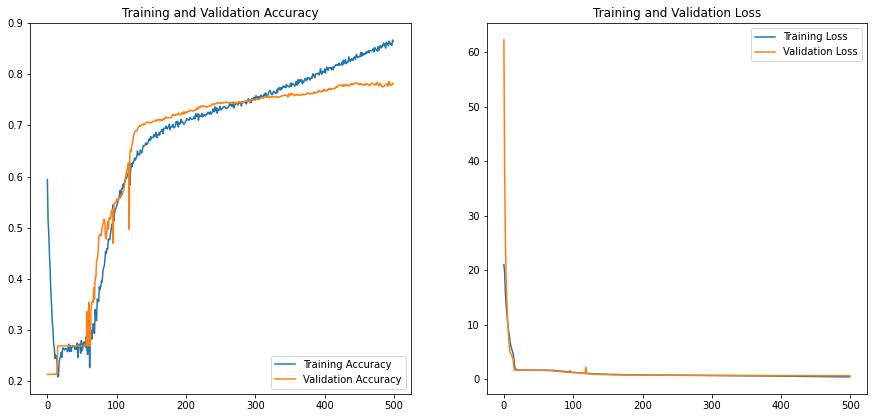

In [ ]:
epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Model - 3**

---

In [ ]:
from keras.layers import Dense, Convolution2D, Flatten, Dropout,MaxPooling2D,Conv2D
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
def network(training_ds,val_ds):
  
  im_shape=(224,224,1)
  inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
  conv1_1=Conv2D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
  conv1_1=BatchNormalization()(conv1_1)
  pool1=MaxPooling2D(pool_size=(3), strides=(2), padding="same")(conv1_1)

  conv2_1=Conv2D(64, (3), activation='relu')(pool1)
  conv2_1=BatchNormalization()(conv2_1)
  pool2=MaxPooling2D(pool_size=(2), strides=(2), padding="same")(conv2_1)

  conv3_1=Conv2D(64, (3), activation='relu')(pool2)
  conv3_1=BatchNormalization()(conv3_1)
  pool3=MaxPooling2D(pool_size=(2), strides=(2), padding="same")(conv3_1)

  flatten=Flatten()(pool3)
  dense_end1 = Dense(64, activation='relu')(flatten)
  dense_end2 = Dense(32, activation='relu')(dense_end1)
  main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)


  model = Model(inputs= inputs_cnn, outputs=main_output)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])


  callbacks = [EarlyStopping(monitor='val_loss', patience=8),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]



  history=model.fit(training_ds, epochs=40,callbacks=callbacks, batch_size=32,validation_data=val_ds)
  model.load_weights('best_model.h5')
  return(model,history)
    

In [ ]:
model,history=network(training_ds=training_ds,val_ds=val_ds)

Epoch 1/40
189/189 [==============================] - 182s 962ms/step - loss: 5.9343 - accuracy: 0.8989 - val_loss: 135.8397 - val_accuracy: 0.0717
Epoch 2/40
189/189 [==============================] - 183s 967ms/step - loss: 5.7183 - accuracy: 0.8591 - val_loss: 1341.6213 - val_accuracy: 0.1389
Epoch 3/40
189/189 [==============================] - 181s 956ms/step - loss: 4.4294 - accuracy: 0.7498 - val_loss: 3.5840 - val_accuracy: 0.2136
Epoch 4/40
189/189 [==============================] - 186s 985ms/step - loss: 1.7333 - accuracy: 0.6964 - val_loss: 2.7176 - val_accuracy: 0.2719
Epoch 5/40
189/189 [==============================] - 215s 1s/step - loss: 1.8847 - accuracy: 0.6029 - val_loss: 2.4472 - val_accuracy: 0.2136
Epoch 6/40
189/189 [==============================] - 202s 1s/step - loss: 1.3482 - accuracy: 0.3103 - val_loss: 1.4473 - val_accuracy: 0.3695
Epoch 7/40
189/189 [==============================] - 182s 961ms/step - loss: 1.1862 - accuracy: 0.4314 - val_loss: 1.2449 - 

## **Model - 4 (Epochs incomplete)**

---

In [ ]:
IMAGE_SIZE = (224,224)

In [ ]:
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(64, (3,3),strides = (1,1), input_shape = (224,224,1),kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides= (2,2)))

model.add(Conv2D(128, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides= (2,2)))

model.add(Conv2D(256, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(Conv2D(256, (3,3),strides = (1,1),kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides= (2,2)))

model.add(Flatten())

model.add(Dense(2048))
model.add(keras.layers.ELU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))



model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(training_ds,
         validation_data=val_ds,
         batch_size=32,
         epochs=60,

)

Epoch 1/60
189/189 [==============================] - 795s 4s/step - loss: 2.1166 - accuracy: 0.3430 - val_loss: 25.4381 - val_accuracy: 0.2684
Epoch 2/60
189/189 [==============================] - 856s 5s/step - loss: 2.0737 - accuracy: 0.2319 - val_loss: 2.3214 - val_accuracy: 0.2694
Epoch 3/60
189/189 [==============================] - 828s 4s/step - loss: 1.8972 - accuracy: 0.2500 - val_loss: 2.8270 - val_accuracy: 0.1728
Epoch 4/60
 74/189 [==========>...................] - ETA: 7:21 - loss: 1.8141 - accuracy: 0.2356

KeyboardInterrupt: ignored

## **Model - 5 (Epochs incomplete) -Pretrained-Vgg16**


---

In [ ]:
from keras.layers import *


img_size_target = 224
img_input = Input(shape=(img_size_target, img_size_target, 1))
img_conc = Concatenate()([img_input, img_input, img_input])  
model = VGG16(input_tensor=img_conc)

553476096/553467096 [==============================] - 2s 0us/step


In [ ]:
from keras.applications.vgg16 import VGG16
from keras import models

num_classes = 5

vgg = VGG16(include_top=False,pooling='avg',weights='imagenet',input_tensor=img_conc)

vgg.summary()

Model: "vgg16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 224, 224, 3)  0           ['input_7[0][0]',                
                                                                  'input_7[0][0]',                
                                                                  'input_7[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['concatenate_1[0][0]']      

In [ ]:
from keras.models import Model

layer_name = 'block1_pool'

my_model= Model(inputs=vgg.input, outputs=vgg.get_layer(layer_name).output)
my_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 224, 224, 3)  0           ['input_7[0][0]',                
                                                                  'input_7[0][0]',                
                                                                  'input_7[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['concatenate_1[0][0]']    

In [ ]:
model = models.Sequential()

model.add(my_model)

from keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization, GlobalAveragePooling2D,Input

In [ ]:
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5,activation='softmax'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, 112, 112, 64)      38720     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 28, 28, 256)      0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_6   (None, 256)             

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(training_ds, epochs=40,callbacks=callbacks, batch_size=32,validation_data=val_ds)
model.load_weights('best_model.h5')


Epoch 1/40
189/189 [==============================] - 176s 930ms/step - loss: 1.6780 - accuracy: 0.2088 - val_loss: 6.1175 - val_accuracy: 0.2684
Epoch 2/40
189/189 [==============================] - 176s 930ms/step - loss: 1.6300 - accuracy: 0.1843 - val_loss: 232.2845 - val_accuracy: 0.0717
Epoch 3/40
189/189 [==============================] - 175s 929ms/step - loss: 1.6299 - accuracy: 0.1773 - val_loss: 1.7317 - val_accuracy: 0.2480
Epoch 4/40
189/189 [==============================] - 175s 928ms/step - loss: 1.6283 - accuracy: 0.1587 - val_loss: 1.6139 - val_accuracy: 0.2126
Epoch 5/40
189/189 [==============================] - 175s 927ms/step - loss: 1.6198 - accuracy: 0.1413 - val_loss: 1.5877 - val_accuracy: 0.3645
Epoch 6/40
189/189 [==============================] - 176s 933ms/step - loss: 1.6126 - accuracy: 0.1579 - val_loss: 1.5718 - val_accuracy: 0.2490
Epoch 7/40
189/189 [==============================] - 177s 935ms/step - loss: 1.6075 - accuracy: 0.1594 - val_loss: 1.5937

KeyboardInterrupt: ignored

## **Model - 6** 

---

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [ ]:
# img_rows, img_cols = 720, 576
# input_shape = (img_rows, img_cols, 1)

In [ ]:
cnn3 = Sequential()
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,1)))
cnn3.add(BatchNormalization())

cnn3.add(MaxPooling2D((2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(5, activation='softmax'))

cnn3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
cnn3.fit(training_ds,
         validation_data=val_ds,
         batch_size=32,
         epochs=11,
         verbose='auto',
)

Epoch 1/11
189/189 [==============================] - 97s 513ms/step - loss: 59.4232 - accuracy: 0.4864 - val_loss: 1.6233 - val_accuracy: 0.1982
Epoch 2/11
189/189 [==============================] - 97s 514ms/step - loss: 1.5517 - accuracy: 0.2346 - val_loss: 1.5805 - val_accuracy: 0.2321
Epoch 3/11
189/189 [==============================] - 97s 513ms/step - loss: 1.3650 - accuracy: 0.3571 - val_loss: 1.4438 - val_accuracy: 0.3167
Epoch 4/11
189/189 [==============================] - 97s 515ms/step - loss: 1.2519 - accuracy: 0.4290 - val_loss: 1.4320 - val_accuracy: 0.2829
Epoch 5/11
189/189 [==============================] - 98s 518ms/step - loss: 4.9769 - accuracy: 0.6262 - val_loss: 1.6290 - val_accuracy: 0.2126
Epoch 6/11
189/189 [==============================] - 98s 517ms/step - loss: 3.2352 - accuracy: 0.7382 - val_loss: 1.9433 - val_accuracy: 0.3884
Epoch 7/11
189/189 [==============================] - 97s 513ms/step - loss: 1.1552 - accuracy: 0.5405 - val_loss: 3.4759 - val_a

In [ ]:
# cnn4 = Sequential()
# cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# cnn4.add(BatchNormalization())

# cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# cnn4.add(BatchNormalization())
# cnn4.add(MaxPooling2D(pool_size=(2, 2)))
# cnn4.add(Dropout(0.25))

# cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# cnn4.add(BatchNormalization())
# cnn4.add(Dropout(0.25))

# cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# cnn4.add(BatchNormalization())
# cnn4.add(MaxPooling2D(pool_size=(2, 2)))
# cnn4.add(Dropout(0.25))

# cnn4.add(Flatten())

# cnn4.add(Dense(512, activation='relu'))
# cnn4.add(BatchNormalization())
# cnn4.add(Dropout(0.5))

# cnn4.add(Dense(128, activation='relu'))
# cnn4.add(BatchNormalization())
# cnn4.add(Dropout(0.5))

# cnn4.add(Dense(5, activation='softmax'))

# cnn4.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adam(),
#               metrics=['accuracy'])

# Testing and Junkies

### Do Not Run These unless testing something

In [ ]:
augmented_path = "C:\\Users\\anant\\jupyterBooks\\LectureNotebooks\\2022W\\AML_2404_LAB\\data1\\augmented"
        

for foldername in os.listdir(augmented_path): # retrieving the image files in the particular folder
    
    folder = augmented_path+"\\"+foldername
    copy_path = augmented_path+'\\'+foldername+'\\cropped\\'
    print(copy_path)
    count = 0
    
    for filename in os.listdir(folder):
    
        if filename != 'cropped':
            count += 1
            image = cv2.imread(folder+"\\"+filename) #reading the images
            imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converting the image to grayscale
            
            ret, thresh = cv2.threshold(imgray, 0, 1, 0) #finding image threshold
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # finding all the contours using chain approx none, chain_approx_simple creating many no of contours
            
            contour_max = max(contours, key = cv2.contourArea) # finding the highest contour for cropping the image
            
            x,y,w,h = cv2.boundingRect(contour_max) # getting the co-ordinates
            image = image[y:y+h, x:x+w] # cropping the frame
            cv2.imwrite(copy_path + f'{foldername}_{count}.jpg', image)

        else:
            pass
        

C:\Users\anant\jupyterBooks\LectureNotebooks\2022W\AML_2404_LAB\data1\augmented\abnormalHR\cropped\
C:\Users\anant\jupyterBooks\LectureNotebooks\2022W\AML_2404_LAB\data1\augmented\covid19\cropped\


KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import cv2

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array

## Testing Augmenting image code

In [ ]:
path = "C:\\Users\\anant\\jupyterBooks\\LectureNotebooks\\2022W\\AML_2404_LAB\\data\\test"
os.chdir(path)
print(os.listdir(os.curdir))
filename = "abnormalHR_14"

img_batch_size = 8

data_gen_args = dict(
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     fill_mode='constant',
                     cval=255
                    )
image_datagen = ImageDataGenerator(**data_gen_args)


img = cv2.imread("abnormalHR_14.jpg")


reshaped_np_arr = img.reshape((1,)+img.shape)
count = 0

#             generating the augmentation of images
for batch in image_datagen.flow(
    reshaped_np_arr,
    batch_size=1,
    save_to_dir=os.curdir,
    save_prefix = filename,
    save_format='jpeg',
    seed=20
):

    count += 1
    if count == img_batch_size:
        break

['abnormalHR_0.jpg_0_840.jpeg', 'abnormalHR_0_cropped.jpeg.jpg', 'abnormalHR_124_cropped.jpeg.jpg', 'abnormalHR_14.jpg', 'abnormalHR_24.jpg_0_9181.jpeg', 'Screenshot 2022-03-28 222642.jpg']


In [ ]:
path = "C:\\Users\\anant\\jupyterBooks\\LectureNotebooks\\2022W\\AML_2404_LAB\\data\\test"
os.chdir(path)
print(os.listdir(os.curdir))
img = cv2.imread('abnormalHR_0.jpg_0_840.jpeg')

imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0, 1, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(type(contours))
print(len(contours))

if len(contours) != 0:
        
    c = max(contours, key = cv2.contourArea)
    contour_image = cv2.drawContours(img, contours, -1, (255,0,0), 3)
    cv2.imshow("out", contour_image)
    cv2.waitKey(0)
    x,y,w,h = cv2.boundingRect(c)
        
    rect = contour_image[y:y+h, x:x+w]
    cv2.imshow("out", rect)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

['abnormalHR_0.jpg_0_840.jpeg']
<class 'tuple'>
2


In [ ]:
path = "C:\\Users\\anant\\jupyterBooks\\LectureNotebooks\\2022W\\AML_2404_LAB\\data\\test"
os.chdir(path)
print(os.listdir(os.curdir))
filename = "abnormalHR_124_cropped.jpeg"
image = cv2.imread("abnormalHR_24.jpg_0_9181.jpeg") #reading the images

imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converting the image to grayscale
ret, thresh = cv2.threshold(imgray, 0, 1, 0) #finding image threshold
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# finding all the contours using chain approx none, chain_approx_simple creating many no of contours
print(hierarchy)
print(len(contours))

contour_max = max(contours, key = cv2.contourArea) # finding the highest contour for cropping the image

x,y,w,h = cv2.boundingRect(contour_max) # getting the co-ordinates

image = image[y:y+h, x:x+w] # cropping the frame
cv2.imwrite(f'{filename}.jpg', image)

['abnormalHR_0.jpg_0_840.jpeg', 'abnormalHR_0_cropped.jpeg.jpg', 'abnormalHR_124_cropped.jpeg.jpg', 'abnormalHR_24.jpg_0_9181.jpeg', 'Screenshot 2022-03-28 222642.jpg']
[[[ -1  -1   1  -1]
  [  2  -1  -1   0]
  [  3   1  -1   0]
  ...
  [358 356  -1   0]
  [359 357  -1   0]
  [ -1 358  -1   0]]]
360


True

In [ ]:
path = "C:\\Users\\anant\\jupyterBooks\\LectureNotebooks\\2022W\\AML_2404_LAB\\data\\test"
os.chdir(path)
print(os.listdir(os.curdir))
img = cv2.imread('abnormalHR_0.jpg_0_840.jpeg', cv2.IMREAD_GRAYSCALE)

# contours, _ = cv2.findContours(...) # Your call to find the contours using OpenCV 2.4.x
blur = cv2.GaussianBlur(img,(5,5),0)
ret, threshold = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
contrs, _ = cv2.findContours(threshold,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) # using threshold to get the contours

contrs_list = list(contrs)
contrs_list.remove(max(contrs_list, key = cv2.contourArea)) # removing the frame
# again getting the largest frame that is the pulse frame

c = max(contrs_list, key = cv2.contourArea)


x,y,w,h = cv2.boundingRect(c) # getting the co-ordinates


rect = img[y:y+h, x:x+w] # cropping the frame

#                 cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),10) # drawing rectangle with the co-ordinates

#                 gamma_corrected = gammaCorrection(rect,3) # gamma correction

#                 (thresh, im_bw) = cv2.threshold(gamma_corrected, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # threshold is increased

#                 im_bw_resize = cv2.resize(im_bw,(720, 576)) # resizing the image to 256
# img = Image.fromarray(rect)


cv2.imshow('image',rect)
# cv2.drawContours(img, contrs, 3, (0,255,0), 3)
cv2.waitKey(0)
cv2.destroyAllWindows()

#thrsh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,41,21) 

# canny_output = cv2.Canny(img, thrsh, thrsh * 2)
# contours, _ = cv2.findContours(thrsh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Your call to find the contours
# print(contours)

# # Draw contours
# drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
# for i in range(len(contours)):
#     color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
#     cv.drawContours(drawing, contours, i, color, 2, cv.LINE_8, hierarchy, 0)
# # Show in a window
# cv.imshow('Contours', drawing)



['abnormalHR_0.jpg_0_840.jpeg']
<class 'numpy.ndarray'>
(101, 1, 2)


In [ ]:
idx = 2 # The index of the contour that surrounds your object
mask = np.zeros_like(img) # Create mask where white is what we want, black otherwise
cv2.drawContours(mask, contours, idx, 255, -1) # Draw filled contour in mask
out = np.zeros_like(img) # Extract out the object and place into output image
out[mask == 255] = img[mask == 255]

# Show the output image
cv2.imshow('Output', out)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
path = "C:\\Users\\anant\\jupyterBooks\\LectureNotebooks\\2022W\\AML_2404_LAB\\data\\test"
os.chdir(path)
print(os.listdir(os.curdir))
img = cv2.imread('abnormalHR_0.jpg_0_840.jpeg') # Read in your image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) 

kernel = np.ones((9,9), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# put mask into alpha channel of result
result = img.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

# save resulting masked image
#cv2.imwrite('retina_masked.png', result)
cv2.imshow('Output', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

['abnormalHR_0.jpg_0_840.jpeg']


In [ ]:
# PATH = "data/covid19/"


# for filename in os.listdir(PATH):
#     img = Image.open(os.path.join(PATH, filename)) # images are color images
#     img = img.resize((1920,1080), Image.BICUBIC)
#     img.save(Copy_to_path+filename) 

In [ ]:

# filename = 'data/covid19/Binder1_Page_001.jpg'

# size = (720, 576)
# count = 0
# for filename in g
# with Image.open(filename) as im:
#     gray_img = ImageOps.grayscale(im)
#     gray_img.save('data/covid19/processed/covid001'+'.jpeg')

In [ ]:
# file_path = "data/covid19/Binder1_Page_017"
# Copy_to_path="data/covid19/processed/"

# count = 0

# for filename in glob.glob(f'{file_path}.jpg'):
#     count += 1
#     with Image.open(filename) as img:
#         img = img.convert('L')
#         img = img.filter(ImageFilter.SHARPEN)
#         img = img.filter(ImageFilter.EDGE_ENHANCE)
        
#         #img = img.filter(ImageFilter.CONTOUR)    
#         #img = img.filter(ImageFilter.EMBOSS)
#         #img = img.filter(ImageFilter.EDGE_ENHANCE)
#         image = np.array(img) # converting PIL image to numpy array
        
#         thrsh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 21) 

#         contrs, _ = cv2.findContours(thrsh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) # using threshold to get the contours
#         contrs = list(contrs)
        
#         c = max(contrs, key = cv2.contourArea)
        
#         contrs.remove(max(contrs, key = cv2.contourArea)) # removing the frame

#         c = max(contrs, key = cv2.contourArea) # again getting the largest frame that is the pulse frame

#         x,y,w,h = cv2.boundingRect(c) # getting the co-ordinates


#         rect = image[y:y+h, x:x+w] # cropping the frame

#         cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),10) # drawing rectangle with the co-ordinates

#         gamma_corrected = gammaCorrection(rect,3) # gamma correction

#         (thresh, im_bw) = cv2.threshold(gamma_corrected, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # threshold is increased
        
#         print(type(im_bw))
#         processed_img = Image.fromarray(im_bw) #Converting the array to image
#         processed_img.show()
#         processed_img.save(Copy_to_path+f'/covid19_{count}.jpg', 'JPEG') 
